In [1]:
from load_dataset import load_admission_dataset
from model_manager import PytorchModelManager
from cf_engine.engine import CFEnginePytorch
from cf_engine.counterfactual import CounterfactualExampleBySubset

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
dataset = load_admission_dataset()
mm = PytorchModelManager(dataset)
dm = mm.get_dir_manager()
# try:
#     mm.load_model()
# except FileNotFoundError:
#     mm.train()
#     mm.save_model()
mm.train()
mm.save_model()
engine = CFEnginePytorch(mm, dataset)

/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, loss=0.421, train_accuracy=0.710, test_accuracy=0.620
Epoch: 1, loss=0.435, train_accuracy=0.802, test_accuracy=0.820
Epoch: 2, loss=0.623, train_accuracy=0.807, test_accuracy=0.820
Epoch: 3, loss=0.469, train_accuracy=0.810, test_accuracy=0.840
Epoch: 4, loss=0.311, train_accuracy=0.805, test_accuracy=0.840
Epoch: 5, loss=0.418, train_accuracy=0.812, test_accuracy=0.830
Epoch: 6, loss=0.158, train_accuracy=0.818, test_accuracy=0.830
Epoch: 7, loss=0.431, train_accuracy=0.823, test_accuracy=0.840
Epoch: 8, loss=0.437, train_accuracy=0.828, test_accuracy=0.840
Epoch: 9, loss=0.207, train_accuracy=0.843, test_accuracy=0.860
Epoch: 10, loss=0.206, train_accuracy=0.845, test_accuracy=0.830
Epoch: 11, loss=0.484, train_accuracy=0.850, test_accuracy=0.820
Epoch: 12, loss=0.321, train_accuracy=0.848, test_accuracy=0.820
Epoch: 13, loss=0.415, train_accuracy=0.863, test_accuracy=0.840
Epoch: 14, loss=0.381, train_accuracy=0.845, test_accuracy=0.830
Epoch: 15, loss=0.276, train_accura

In [4]:
target_name = dataset.get_target_names(False)
pre_target_name = '{}_pred'.format(target_name)
desc = dataset.get_description()
neg = False
pos = True
def plot_subset_cf(subset_attr_cf):
    for i, (feature, subset_cf) in enumerate(subset_attr_cf.items()):
        cf_df = subset_cf.get_cf().reset_index(drop=True)
        original_df = subset_cf.get_instance().reset_index(drop=True)
#         valid_index = cf_df[pre_target_name] != \
#             original_df.loc[cf_df['OriginIndex'], pre_target_name]
#         valid_cf = cf_df.loc[valid_index, :]
#         valid_instance = original_df.loc[valid_cf['OriginIndex'], :]
        valid_index = cf_df[pre_target_name] != original_df[pre_target_name]
        valid_cf = cf_df[valid_index]
        valid_instance = original_df[valid_index]
        pos_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == pos][feature]
        neg_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == neg][feature]
        pos_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == pos][feature]
        neg_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == neg][feature]
        # add subplots
        bins = 25
        plt.subplot(len(subset_attr_cf), 2, i*2+1)
        if desc[feature]['type'] == 'numerical':
            plt.hist(neg_valid_instance_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
            plt.hist(pos_valid_cf_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_instance_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_cf_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
        
        plt.legend(loc='upper right')
        plt.title('{}: neg->pos'.format(feature))
        plt.subplot(len(subset_attr_cf), 2, i*2+2)
        if desc[feature]['type'] == 'numerical':
            plt.hist(pos_valid_instance_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
            plt.hist(neg_valid_cf_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_cf_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_instance_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
        plt.legend(loc='upper right')
        plt.title('{}: pos->neg'.format(feature))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

[500/500]  Epoch-0, time cost: 5.976s, loss: 26.256, iteration: 2000, validation rate: 0.984
Total time cost: 6.049, validation rate: 0.984, average distance: 0.966, average loss: 26.256


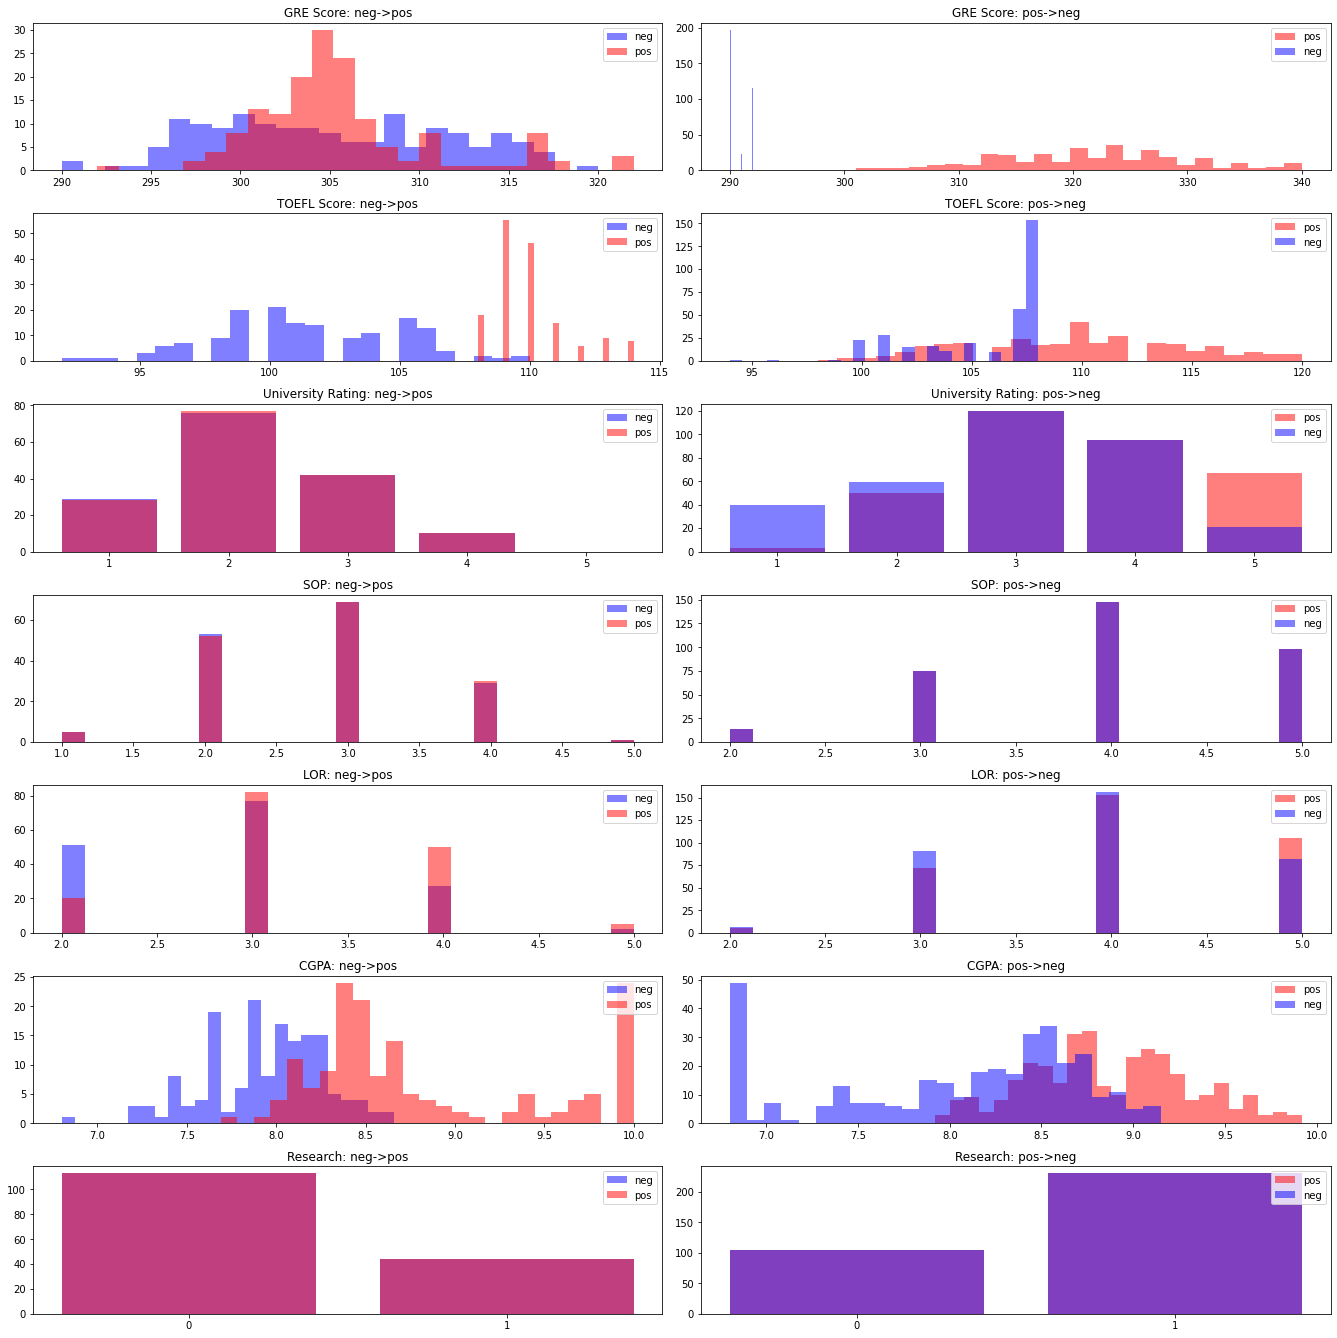

In [5]:
subset = {}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plot_subset_cf(subset_attr_cf)

[184/184]  Epoch-0, time cost: 4.158s, loss: 28.459, iteration: 2000, validation rate: 0.728
Total time cost: 4.233, validation rate: 0.728, average distance: 0.963, average loss: 28.459
[184/184]  Epoch-0, time cost: 4.192s, loss: 20.594, iteration: 2000, validation rate: 0.853
Total time cost: 4.268, validation rate: 0.853, average distance: 1.374, average loss: 20.594


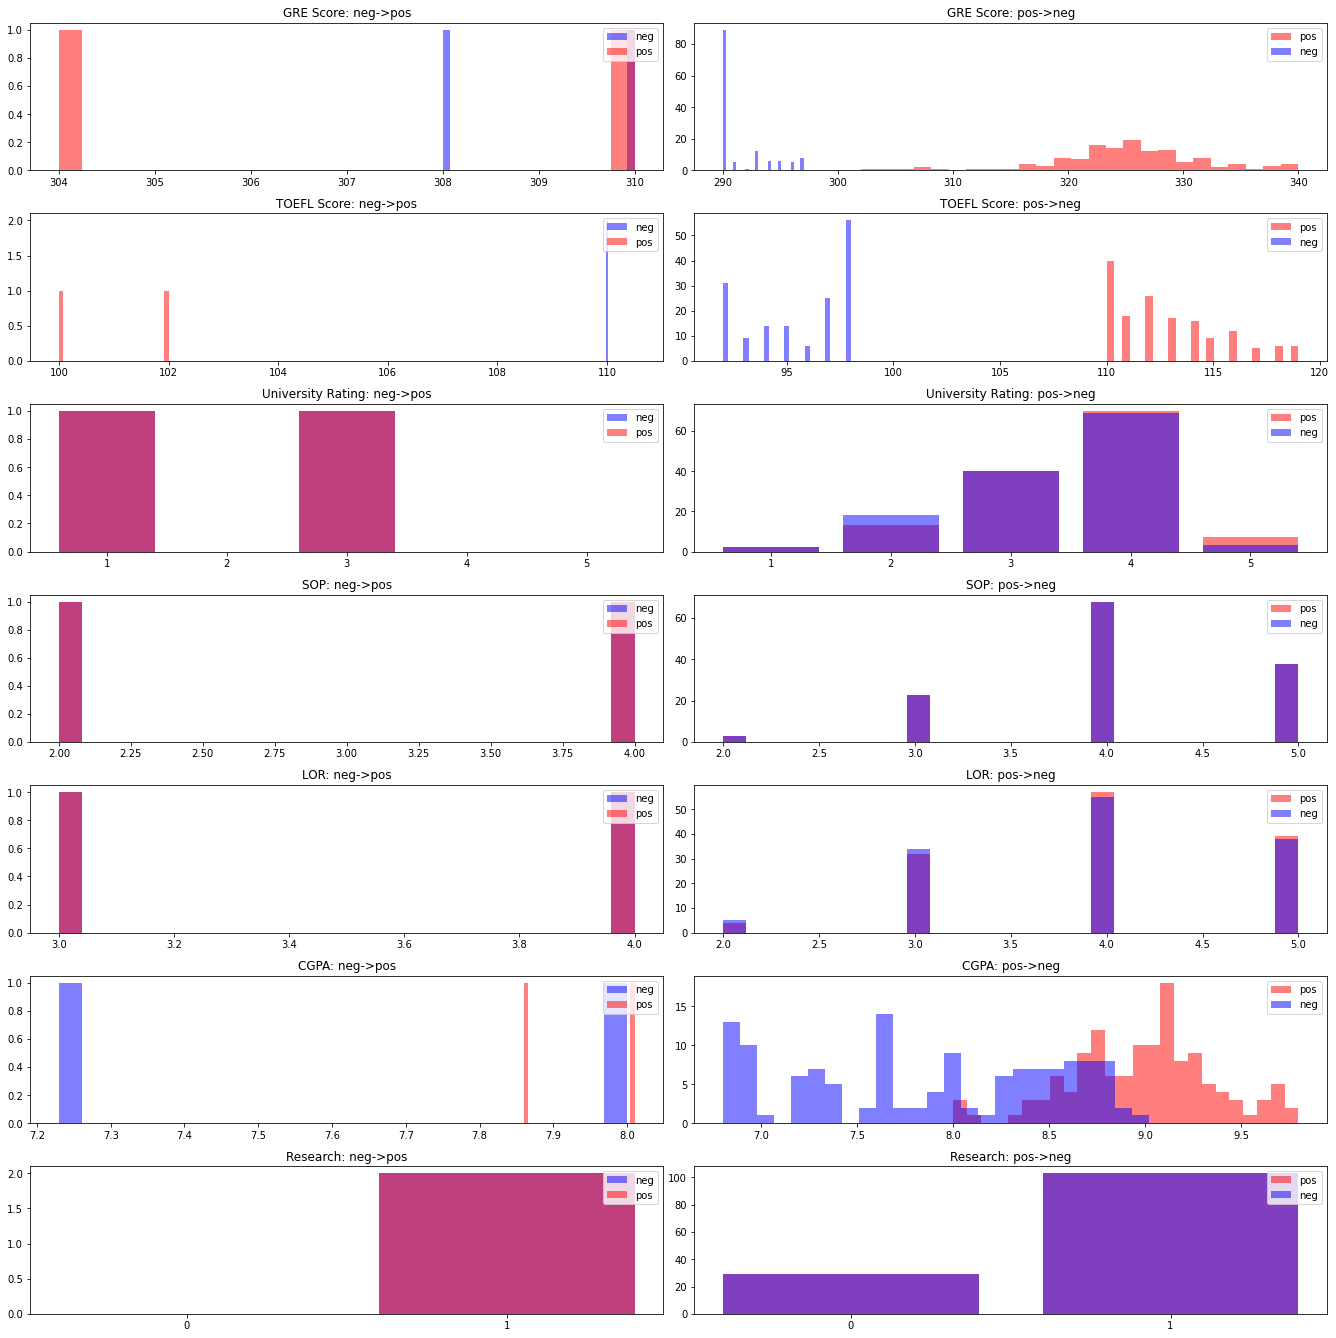

In [6]:
subset = {'TOEFL Score': {'min': 110, 'max': 120}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plot_subset_cf(subset_attr_cf)